# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [3]:
%pip install iso3166

### Upgrade Plotly

Run the cell below if you are working with Google Colab.

In [4]:
%pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


### Import Statements

In [5]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# These might be helpful:
from iso3166 import countries
from datetime import datetime, timedelta

### Notebook Presentation

In [6]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [7]:
df_data = pd.read_csv('mission_launches.csv')
df_data.head()

,Unnamed: 0.1,Unnamed: 0,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


# Preliminary Data Exploration

* What is the shape of `df_data`?
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [8]:
df_data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

print(f"df_data has {df_data.shape[0]} rows and {df_data.shape[1]} columns")
print(f"The columns are {df_data.columns}")

df_data has 4324 rows and 7 columns
The columns are Index(['Organisation', 'Location', 'Date', 'Detail', 'Rocket_Status', 'Price',
       'Mission_Status'],
      dtype='object')


In [9]:
print(df_data.isna().values.sum())

3360


## Descriptive Statistics

In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Organisation    4324 non-null   object
 1   Location        4324 non-null   object
 2   Date            4324 non-null   object
 3   Detail          4324 non-null   object
 4   Rocket_Status   4324 non-null   object
 5   Price           964 non-null    object
 6   Mission_Status  4324 non-null   object
dtypes: object(7)
memory usage: 236.6+ KB


# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [11]:
df_data.Date = pd.to_datetime(df_data.Date, format='mixed')

<ipython-input-11-8eedadc2a592>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_data.Date = pd.to_datetime(df_data.Date, format='mixed')


# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned?

In [12]:
rocket_statuses = df_data['Rocket_Status'].value_counts()
rocket_statuses.head()

bar = px.bar(x=rocket_statuses.index,
             y=rocket_statuses.values,
             text=rocket_statuses.values,
             title="Rocket Statuses")

bar.show()

# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [13]:
mission_statuses = df_data['Mission_Status'].value_counts()
mission_statuses.head()

bar = px.bar(x=mission_statuses.index,
             y=mission_statuses.values,
             text=mission_statuses.values,
             title="Mission Statuses")

bar.show()

# How Expensive are the Launches?

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values).

In [14]:
prices = df_data['Price'].value_counts().reset_index()
prices.columns = ['Price', 'Count']

prices['Price'] = prices['Price'].astype(str).str.replace(',','')
prices['Price'] = pd.to_numeric(prices['Price'], errors='coerce')
prices = prices.dropna(subset=['Price'])
prices = prices.sort_values('Price')

prices.head()

,Price,Count
30,5.30,9
39,7.00,5
23,7.50,14
51,12.00,1
52,15.00,1


In [15]:
expanded_prices = prices.loc[prices.index.repeat(prices['Count'])].reset_index(drop=True)

fig = px.histogram(expanded_prices, x='Price')
fig.update_layout(title='Histogram of Prices (Weighted by Count)', bargap=0.2)
fig.show()

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map.
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [16]:
!pip install country_converter
import country_converter as coco

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00


In [17]:
df_countries = df_data['Location'].value_counts().reset_index()
df_countries.columns = ['Location', 'Launches']

df_countries['Location'] = df_countries['Location'].apply(lambda x: x.split(',')[-1].strip())

df_countries.loc[df_countries['Location'] == 'Barents Sea', 'Location'] = 'Russia'
df_countries.loc[df_countries['Location'] == 'Pacific Ocean', 'Location'] = 'USA'
df_countries.loc[df_countries['Location'] == 'New Mexico', 'Location'] = 'USA'
df_countries.loc[df_countries['Location'] == 'Gran Canaria', 'Location'] = 'USA'
df_countries.loc[df_countries['Location'] == 'Pacific Missile Range Facility', 'Location'] = 'USA'
df_countries.loc[df_countries['Location'] == 'Yellow Sea', 'Location'] = 'China'
df_countries.loc[df_countries['Location'] == 'Shahrud Missile Test Site', 'Location'] = 'Iran'

df_countries['iso'] = coco.convert(names=df_countries['Location'], to='ISO3')

df_countries['Launches'] = pd.to_numeric(df_countries['Launches'], errors='coerce')

print(df_countries)
print(df_countries['Launches'].describe())


       Location  Launches  iso
0    Kazakhstan       235  KAZ
1        Russia       216  RUS
2        Russia       202  RUS
3        Russia       198  RUS
4    Kazakhstan       193  KAZ
..          ...       ...  ...
132       Kenya         1  KEN
133         USA         1  USA
134  Kazakhstan         1  KAZ
135         USA         1  USA
136         USA         1  USA

[137 rows x 3 columns]
count   137.00
mean     31.56
std      48.45
min       1.00
25%       3.00
50%      10.00
75%      39.00
max     235.00
Name: Launches, dtype: float64


In [18]:
fig = px.choropleth(
    df_countries,
    locations='iso',
    color='Launches',
    hover_name='Location',
    color_continuous_scale=px.colors.sequential.matter,
)

fig.update_layout(title='Total Rocket Launches by Country')

fig.show()

# Use a Choropleth Map to Show the Number of Failures by Country


In [19]:
df_data['Location'] = df_data['Location'].apply(lambda x: x.split(',')[-1].strip())

df_data.loc[df_data['Location'] == 'Barents Sea', 'Location'] = 'Russia'
df_data.loc[df_data['Location'] == 'Pacific Ocean', 'Location'] = 'USA'
df_data.loc[df_data['Location'] == 'New Mexico', 'Location'] = 'USA'
df_data.loc[df_data['Location'] == 'Gran Canaria', 'Location'] = 'USA'
df_data.loc[df_data['Location'] == 'Pacific Missile Range Facility', 'Location'] = 'USA'
df_data.loc[df_data['Location'] == 'Yellow Sea', 'Location'] = 'China'
df_data.loc[df_data['Location'] == 'Shahrud Missile Test Site', 'Location'] = 'Iran'

df_data['iso'] = coco.convert(names=df_data['Location'], to='ISO3')

df_data.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status,iso
0,SpaceX,USA,2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success,USA
1,CASC,China,2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,CHN
2,SpaceX,USA,2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,USA
3,Roscosmos,Kazakhstan,2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success,KAZ
4,ULA,USA,2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.0,Success,USA


In [20]:
country_failures = (
    df_data[df_data['Mission_Status'] == 'Failure']
    .groupby(['iso', 'Mission_Status'])
    .size()
    .reset_index(name='Failure_Count')
)

country_failures.head()

,iso,Mission_Status,Failure_Count
0,AUS,Failure,3
1,BRA,Failure,2
2,CHN,Failure,19
3,FRA,Failure,13
4,IND,Failure,8


In [21]:
fig = px.choropleth(
    country_failures,
    locations='iso',
    color='Failure_Count',
    color_continuous_scale=px.colors.sequential.matter,
)

fig.update_layout(title='Failures by Country')

fig.show()

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status.

In [22]:
fig = px.sunburst(
    df_data,
    path=['iso', 'Organisation', 'Mission_Status'],
    color='Mission_Status',
    color_discrete_map={
        'Success': 'green',
        'Failure': 'red',
        'Partial Failure': 'orange',
        'Prelaunch Failure': 'gray',
        'Unknown': 'lightblue'
    },
    maxdepth=3
)

fig.update_layout(
    title="Launches by Country, Organisation, and Status",
    margin=dict(t=40, l=0, r=0, b=0)
)

fig.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [23]:
df_data['Price'] = pd.to_numeric(df_data['Price'], errors='coerce')

money = df_data.groupby('Organisation').agg({'Price': pd.Series.sum}).reset_index()

money = money.sort_values('Price', ascending=False)

money.head()

,Organisation,Price
35,NASA,"61,200.00"
3,Arianespace,"16,345.00"
48,ULA,"14,798.00"
7,CASC,"6,340.26"
46,SpaceX,"5,444.00"


In [24]:
bar = px.bar(
    x = money['Organisation'][:10],
    y = money['Price'][:10]
)

bar.show()

# Analyse the Amount of Money Spent by Organisation per Launch

In [25]:
money = df_data.groupby('Organisation').agg(
    Total_Price=('Price', 'sum'),
    Launch_Count=('Price', 'count')
).reset_index()

money['Money_Per_Launch'] = money['Total_Price'] / money['Launch_Count']

money = money.sort_values('Money_Per_Launch', ascending=False)

money.head()


,Organisation,Total_Price,Launch_Count,Money_Per_Launch
35,NASA,"61,200.00",136,450.00
6,Boeing,"1,241.00",7,177.29
3,Arianespace,"16,345.00",96,170.26
48,ULA,"14,798.00",98,151.00
19,ILS,"1,320.00",13,101.54


In [26]:
bar = px.bar(
    x = money['Organisation'][:20],
    y = money['Money_Per_Launch'][:20]
)

bar.show()

# Chart the Number of Launches per Year

In [27]:
df_data['Date'] = pd.to_datetime(df_data['Date'], utc=True)

df_data['Year'] = df_data['Date'].dt.year

print(df_data[['Date', 'Year']].head())

                       Date  Year
0 2020-08-07 05:12:00+00:00  2020
1 2020-08-06 04:01:00+00:00  2020
2 2020-08-04 23:57:00+00:00  2020
3 2020-07-30 21:25:00+00:00  2020
4 2020-07-30 11:50:00+00:00  2020


In [28]:
yearly_launches = df_data.groupby('Year').agg(
    Launch_Count=('Price', 'count')
).reset_index()

yearly_launches.head()

,Year,Launch_Count
0,1957,0
1,1958,0
2,1959,0
3,1960,0
4,1961,0


In [29]:
bar = px.bar(x = yearly_launches.Year,
             y = yearly_launches.Launch_Count)

bar.show()

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart.

In [30]:
df_data['Year_Month'] = df_data['Date'].dt.to_period('M')
monthly_launches = df_data.groupby('Year_Month').size().reset_index(name='Launch_Count')
print(monthly_launches)


    Year_Month  Launch_Count
0      1957-10             1
1      1957-11             1
2      1957-12             1
3      1958-02             2
4      1958-03             3
..         ...           ...
742    2020-04             5
743    2020-05             9
744    2020-06             7
745    2020-07            14
746    2020-08             3

[747 rows x 2 columns]


<ipython-input-30-2201fef8380c>:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [31]:
bar = px.bar(x = monthly_launches['Year_Month'].astype(str),
             y = monthly_launches['Launch_Count'])

bar.show()

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [32]:
df_data['Date'] = pd.to_datetime(df_data['Date'], utc=True)

df_data['Month'] = df_data['Date'].dt.month

monthly_launches = df_data.groupby('Month').agg(
    Launch_Count=('Price', 'count')
).reset_index()

In [33]:
bar = px.bar(x = monthly_launches.Month,
             y = monthly_launches.Launch_Count)

bar.show()

# How has the Launch Price varied Over Time?

Create a line chart that shows the average price of rocket launches over time.

In [34]:
prices_over_time = df_data.groupby('Year').agg(
    Prices=('Price', 'mean')
).reset_index()

prices_over_time['Prices'] = pd.to_numeric(prices_over_time['Prices'])

prices_over_time_sorted = prices_over_time.sort_values(by='Prices', ascending=False)

prices_over_time_sorted.head()

,Year,Prices
24,1981,450.00
28,1985,408.08
34,1991,391.43
32,1989,380.83
27,1984,380.13


In [35]:
bar = px.bar(x = prices_over_time.Year,
             y = prices_over_time.Prices)

bar.show()

# Chart the Number of Launches over Time by the Top 10 Organisations.

How has the dominance of launches changed over time between the different players?

In [36]:
top_10 = df_data['Organisation'].value_counts().nlargest(10).index

df_top_10 = df_data[df_data['Organisation'].isin(top_10)]

launches_over_time = df_top_10.groupby(['Year', 'Organisation']).size().reset_index(name='Launches')

launches_over_time

,Year,Organisation,Launches
0,1957,RVSN USSR,2
1,1958,NASA,2
2,1958,RVSN USSR,5
3,1958,US Air Force,2
4,1959,General Dynamics,1
...,...,...,...
318,2019,VKS RF,8
319,2020,Arianespace,4
320,2020,CASC,19
321,2020,ULA,4


In [37]:
fig = px.line(launches_over_time, x="Year", y="Launches", color='Organisation')
fig.show()

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991.

In [38]:
cold_war = df_data[(df_data['iso']=='USA') | (df_data['iso']=='RUS')]

cold_war = cold_war[cold_war['Year'] <= 1991]

cold_war.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status,iso,Year,Year_Month,Month
1719,Yuzhmash,Russia,1991-12-18 03:54:00+00:00,Tsyklon-3 | Intercosmos 25 & Magion 3,StatusRetired,NaN,Success,RUS,1991,1991-12,12
1721,General Dynamics,USA,1991-12-07 22:47:00+00:00,Atlas II | Eutelsat 2F3,StatusRetired,NaN,Success,USA,1991,1991-12,12
1722,General Dynamics,USA,1991-11-28 13:23:00+00:00,Atlas-E/F Star-37S-ISS | DMSP F-11,StatusRetired,NaN,Success,USA,1991,1991-11,11
1723,RVSN USSR,Russia,1991-11-27 03:30:00+00:00,Cosmos-3M (11K65M) | Cosmos 2173,StatusRetired,NaN,Success,RUS,1991,1991-11,11
1724,NASA,USA,1991-11-24 23:44:00+00:00,Space Shuttle Atlantis | STS-44,StatusRetired,450.00,Success,USA,1991,1991-11,11


## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches.

In [39]:
ussr_usa_counts = cold_war['iso'].value_counts().reset_index()
ussr_usa_counts.columns = ['iso', 'count']

ussr_usa_counts

,iso,count
0,RUS,1188
1,USA,662


In [40]:
fig = px.pie(
    ussr_usa_counts,
    names='iso',
    values='count',
    title='Distribution of Launches: USA vs USSR (Cold War Era)'
)

fig.show()

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

In [41]:
russia_usa = df_data[(df_data['iso']=='USA') | (df_data['iso']=='RUS')].groupby(['Year', 'iso']).size().unstack(fill_value=0)

russia_usa

iso,RUS,USA
Year,,
1957,0,1
1958,0,23
1959,0,16
1960,0,30
1961,2,43
...,...,...
2016,6,27
2017,6,30
2018,8,34


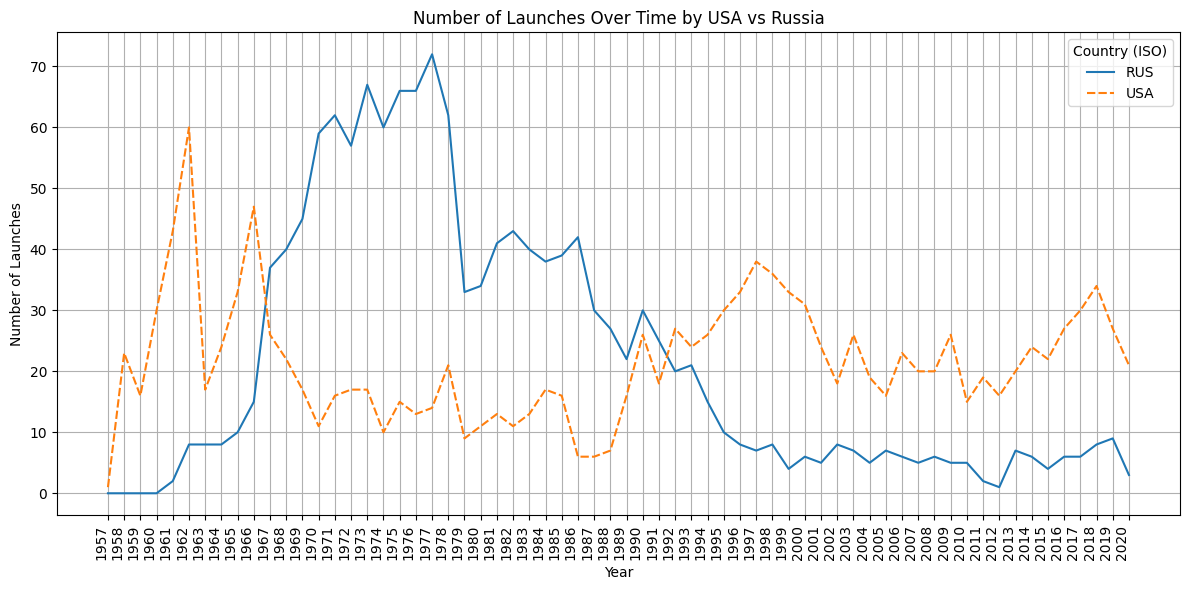

In [42]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=russia_usa)
plt.title('Number of Launches Over Time by USA vs Russia')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.xticks(russia_usa.index, rotation=90, ha='right')
plt.legend(title='Country (ISO)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Chart the Total Number of Mission Failures Year on Year.

In [59]:
failures_over_time = df_data[
    ((df_data['iso'] == 'USA') | (df_data['iso'] == 'RUS')) &
    (df_data['Mission_Status'] == 'Failure')
]

failures_over_time = failures_over_time.groupby(['Year', 'iso']).size().reset_index(name='Total_Failures')


failures_over_time.head()

,Year,iso,Total_Failures
0,1957,USA,1
1,1958,USA,16
2,1959,USA,8
3,1960,USA,14
4,1961,RUS,2


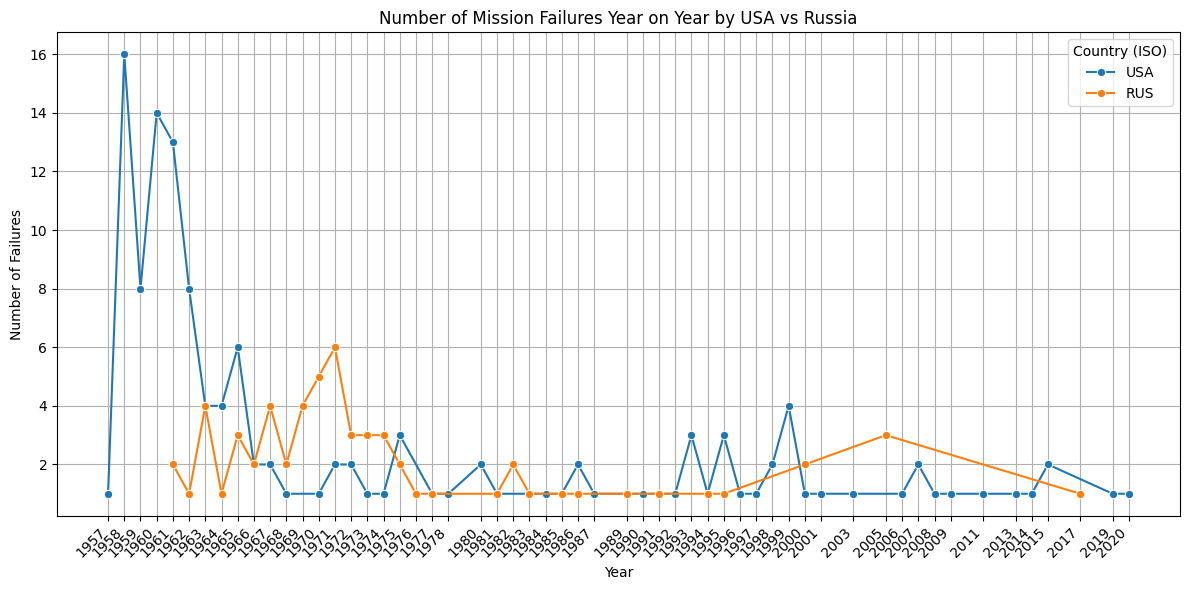

In [57]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=failures_over_time, x='Year', y='Total_Failures', hue='iso', marker='o')
plt.title('Number of Mission Failures Year on Year by USA vs Russia')
plt.xlabel('Year')
plt.ylabel('Number of Failures')
plt.legend(title='Country (ISO)')
plt.grid(True)
plt.xticks(failures_over_time['Year'].unique(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time?

In [65]:
failures_over_time = df_data[(df_data['iso']=='USA') | (df_data['iso']=='RUS')].groupby(['Year', 'iso', 'Mission_Status']).size().unstack(fill_value=0).reset_index()

failures_over_time['failure_rate'] = (failures_over_time['Failure'] + failures_over_time['Partial Failure'] + failures_over_time['Prelaunch Failure']) / (
    failures_over_time['Failure'] + failures_over_time['Partial Failure'] + failures_over_time['Prelaunch Failure'] + failures_over_time['Success'])

failures_over_time.head()

Mission_Status,Year,iso,Failure,Partial Failure,Prelaunch Failure,Success,failure_rate
0,1957,USA,1,0,0,0,1.00
1,1958,USA,16,2,0,5,0.78
2,1959,USA,8,2,0,6,0.62
3,1960,USA,14,0,0,16,0.47
4,1961,RUS,2,0,0,0,1.00


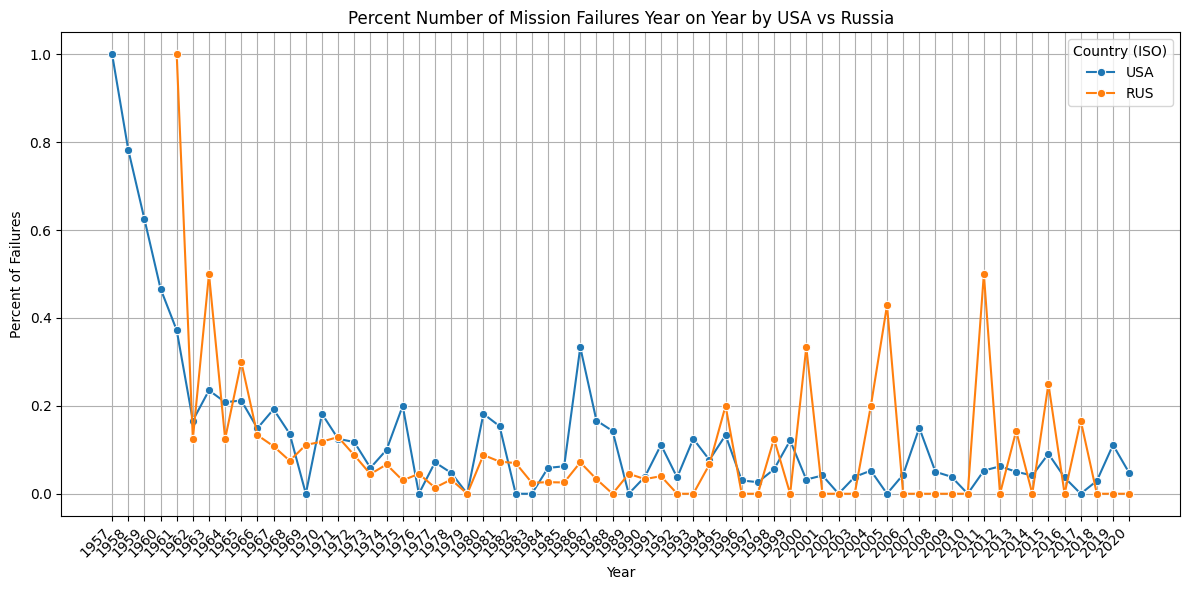

In [67]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=failures_over_time, x='Year', y='failure_rate', hue='iso', marker='o')
plt.title('Percent Number of Mission Failures Year on Year by USA vs Russia')
plt.xlabel('Year')
plt.ylabel('Percent of Failures')
plt.legend(title='Country (ISO)')
plt.grid(True)
plt.xticks(failures_over_time['Year'].unique(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches?

In [78]:
total_launches = df_data.groupby(['Year', 'iso']).size().unstack(fill_value=0)

total_launches.head()

iso,AUS,BRA,CHN,FRA,IND,IRN,ISR,JPN,KAZ,KEN,KOR,NZL,PRK,RUS,USA
Year,,,,,,,,,,,,,,,
1957,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1
1958,0,0,0,0,0,0,0,0,5,0,0,0,0,0,23
1959,0,0,0,0,0,0,0,0,4,0,0,0,0,0,16
1960,0,0,0,0,0,0,0,0,9,0,0,0,0,0,30
1961,0,0,0,0,0,0,0,0,7,0,0,0,0,2,43


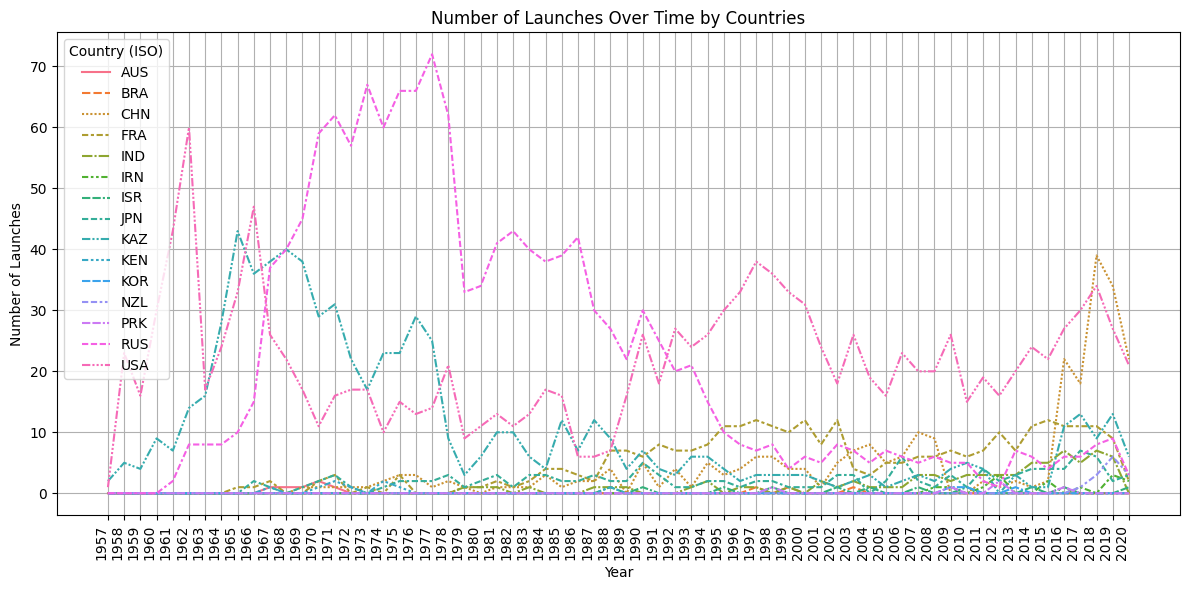

In [79]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_launches)
plt.title('Number of Launches Over Time by Countries')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.xticks(total_launches.index, rotation=90, ha='right')
plt.legend(title='Country (ISO)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020?

In [82]:
total_launches_org = df_data.groupby(['Year', 'Organisation']).size().unstack(fill_value=0)

total_launches_org.head()

Organisation,AEB,AMBA,ASI,Arianespace,Arm??e de l'Air,Blue Origin,Boeing,CASC,CASIC,CECLES,...,SpaceX,Starsem,ULA,US Air Force,US Navy,UT,VKS RF,Virgin Orbit,Yuzhmash,i-Space
Year,,,,,,,,,,,,,,,,,,,,,
1957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1958,0,7,0,0,0,0,0,0,0,0,...,0,0,0,2,12,0,0,0,0,0
1959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,4,0,0,0,0,0
1960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,21,0,0,0,0,0,0
1961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,23,0,0,0,0,0,0


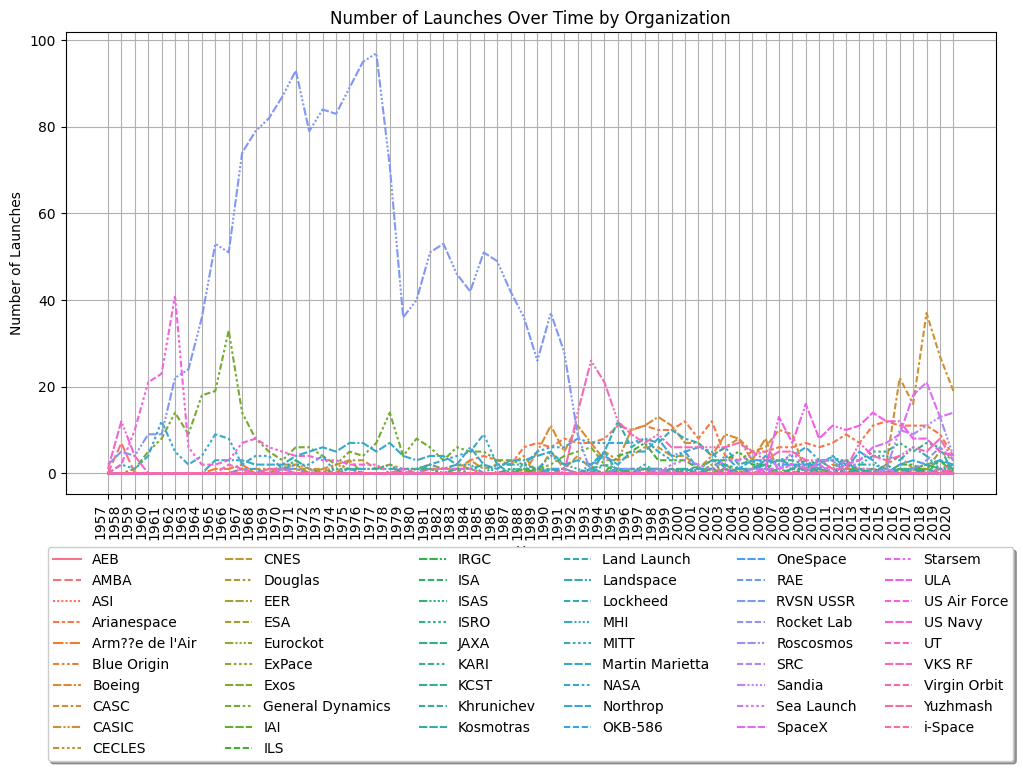

In [93]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_launches_org)
plt.title('Number of Launches Over Time by Organization')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.xticks(total_launches_org.index, rotation=90, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6)
plt.grid(True)
plt.show()